In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
import gc
from tqdm import tqdm_notebook
from functools import reduce

from preprocessing import create_feature_df
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from functools import partial

## Loading data

In [5]:
%%time
common_test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                          511, 516, 1838, 1896]

additional_test_station_id = []

test_station_id = common_test_station_id + additional_test_station_id


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228,
                    239, 305, 308, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis, interpol_freq=20)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_dampness', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY], data[MmxColumns.ID_ROAD_TEMPERATURE]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 37s, sys: 11.4 s, total: 1min 49s
Wall time: 1min 49s


## Predict values

In [95]:
df_test = copy(test)
df_train = copy(train)

def saturated_pressure(T):
    sat_p = 0.61121 * np.exp((18.678 - T / 234.5) * (T / (257.14 + T))) * 1000
    return sat_p

df_test['data_sat_pressure'] = df_test['data_t_air'].apply(saturated_pressure)
df_test['predict_dampness'] = (df_test['data_dampness'].shift(-1) * 
                                 df_test['data_sat_pressure'].shift(-1) *
                                 (df_test['data_t_air'] + 273.15) /
                                 df_test['data_sat_pressure'] / 
                                 (df_test['data_t_air'].shift(-1) + 273.15))
df_test['predict_dampness'] = df_test['predict_dampness'].fillna(76)
df_test.loc[df_test['predict_dampness'] > 100, 'predict_dampness'] = 100

#-----------------------------------------------------------------------------
df_train['data_sat_pressure'] = df_train['data_t_air'].apply(saturated_pressure)
df_train['predict_dampness'] = (df_train['data_dampness'].shift(-1) * 
                                df_train['data_sat_pressure'].shift(-1) *
                                (df_train['data_t_air'] + 273.15) /
                                df_train['data_sat_pressure'] / 
                                (df_train['data_t_air'].shift(-1) + 273.15))
df_train['predict_dampness'] = df_train['predict_dampness'].fillna(76)
df_train.loc[df_train['predict_dampness'] > 100, 'predict_dampness'] = 100

In [96]:
threshold = 10
df_test['label_predict'] = np.abs(df_test['predict_dampness'] - df_test['data_dampness']) > threshold
num_of_outliers = len(df_test[df_test['label_predict']])
percentage = num_of_outliers / len(df_test)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_test)))

Ratio of anomalies is 0.00102% (1329 out of 1309207)


In [97]:
threshold = 10
df_train['label_predict'] = np.abs(df_train['predict_dampness'] - df_train['data_dampness']) > threshold
num_of_outliers = len(df_train[df_train['label_predict']])
percentage = num_of_outliers / len(df_train)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_train)))

Ratio of anomalies is 0.00234% (7621 out of 3262039)


In [98]:
df_train.groupby('station_id')['label_predict'].sum()

station_id
113        47.0
115       161.0
116       145.0
118       126.0
126       151.0
150      2520.0
152        55.0
200      1829.0
223        74.0
228       114.0
239        41.0
305        42.0
308        85.0
401       230.0
411       335.0
432       153.0
435       138.0
454        56.0
456       111.0
593       146.0
628        20.0
1831       88.0
1899       39.0
1911       72.0
1921       54.0
4007       19.0
20323      60.0
20717      38.0
20743      67.0
20754       8.0
20755      39.0
20761      52.0
20916     461.0
20921      45.0
Name: label_predict, dtype: float64

In [99]:
df_test.groupby('station_id')['label_predict'].sum()

station_id
114      76.0
117     104.0
119     121.0
302      87.0
303      35.0
307      53.0
393      35.0
442      44.0
503      29.0
504      33.0
511      22.0
516     164.0
1838    234.0
1896    292.0
Name: label_predict, dtype: float64

## Plot result

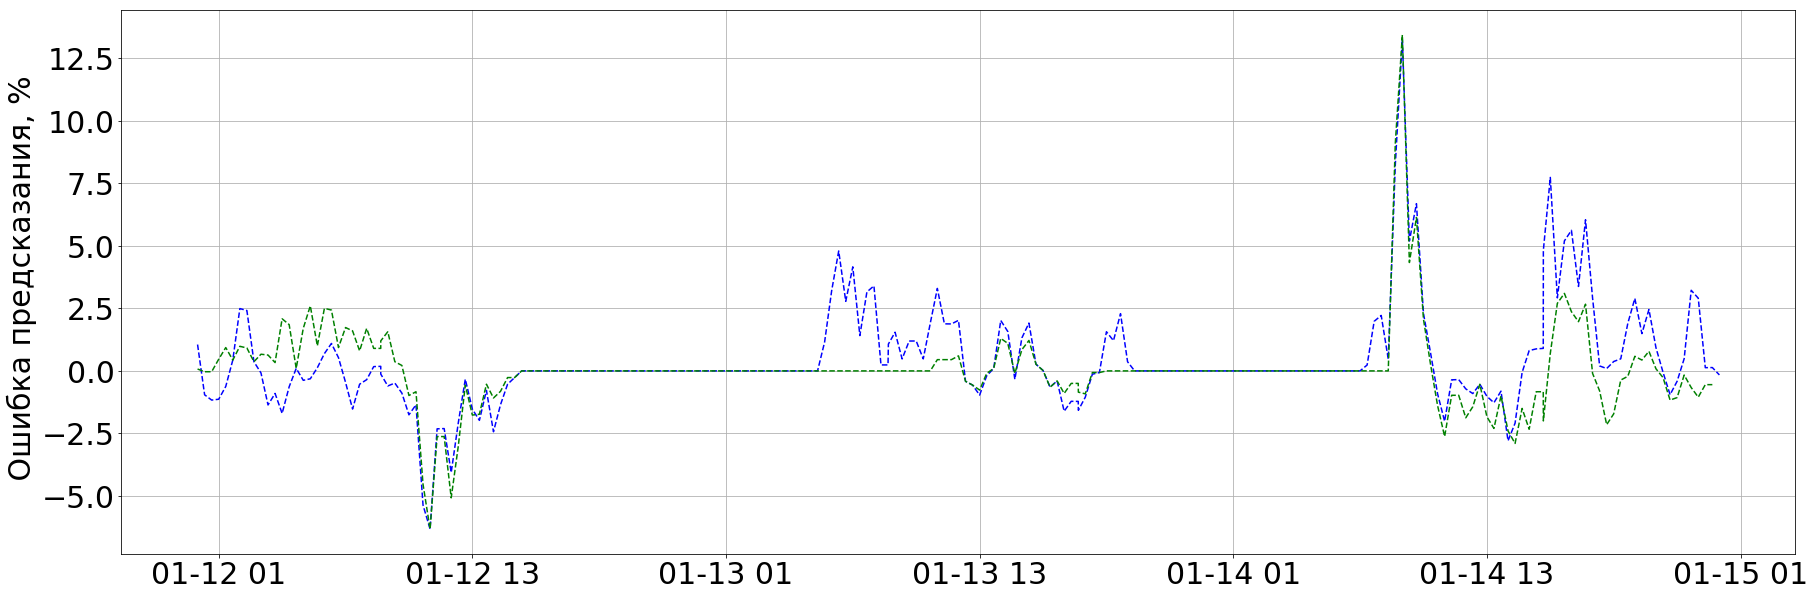

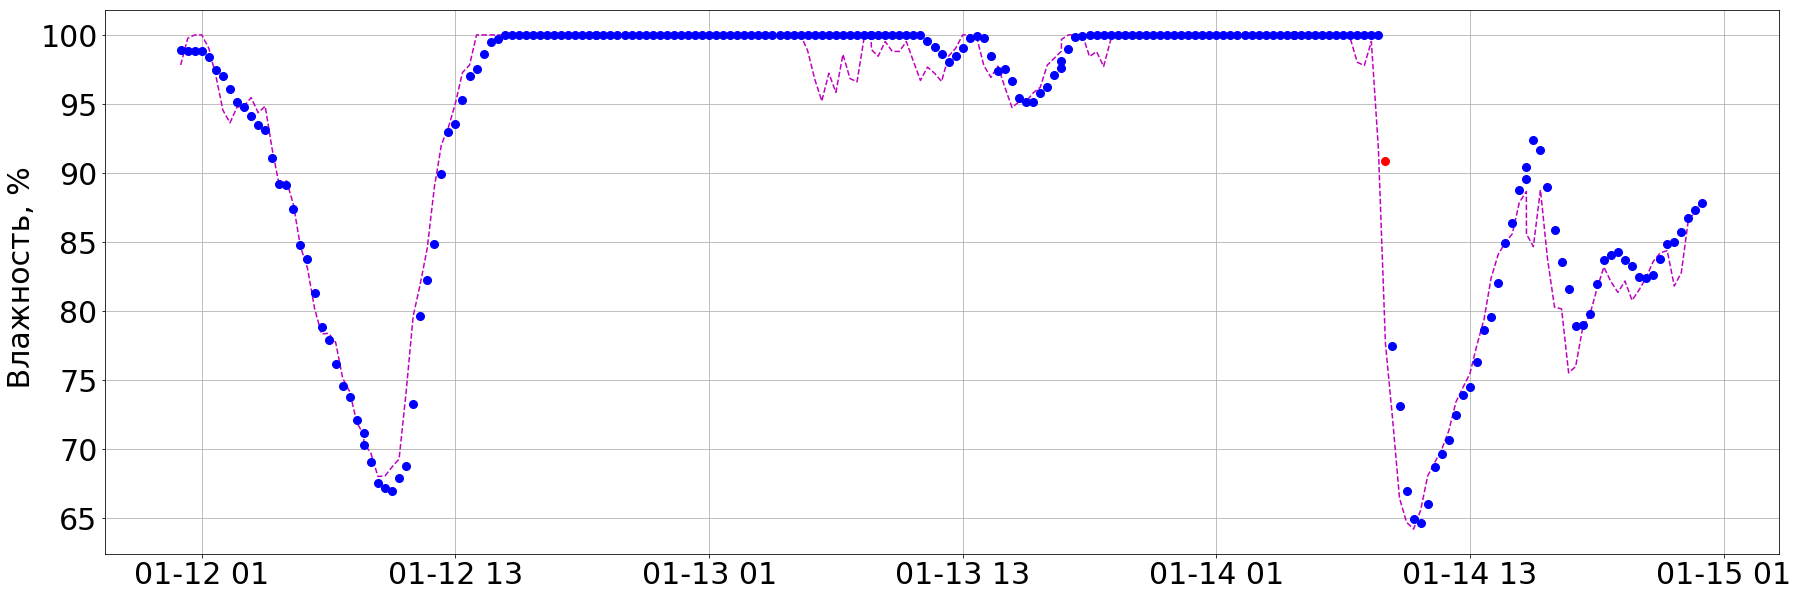

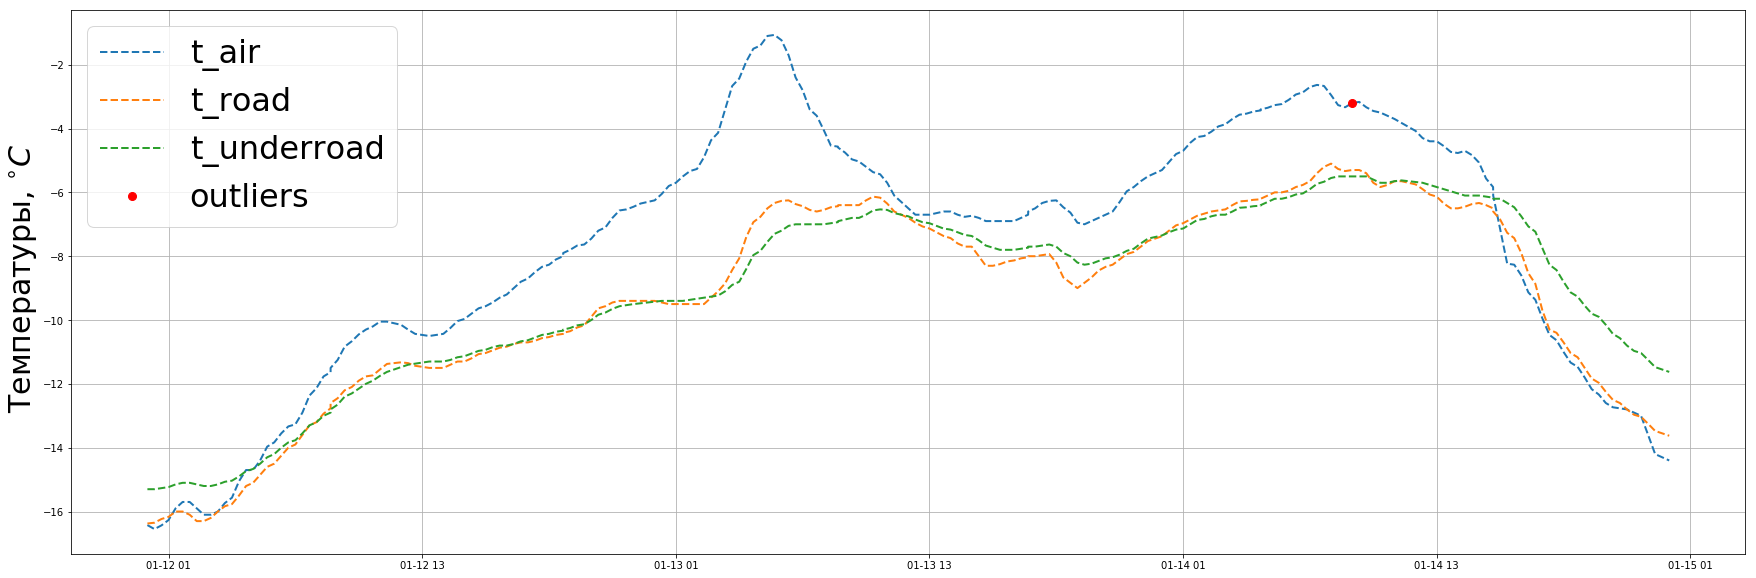

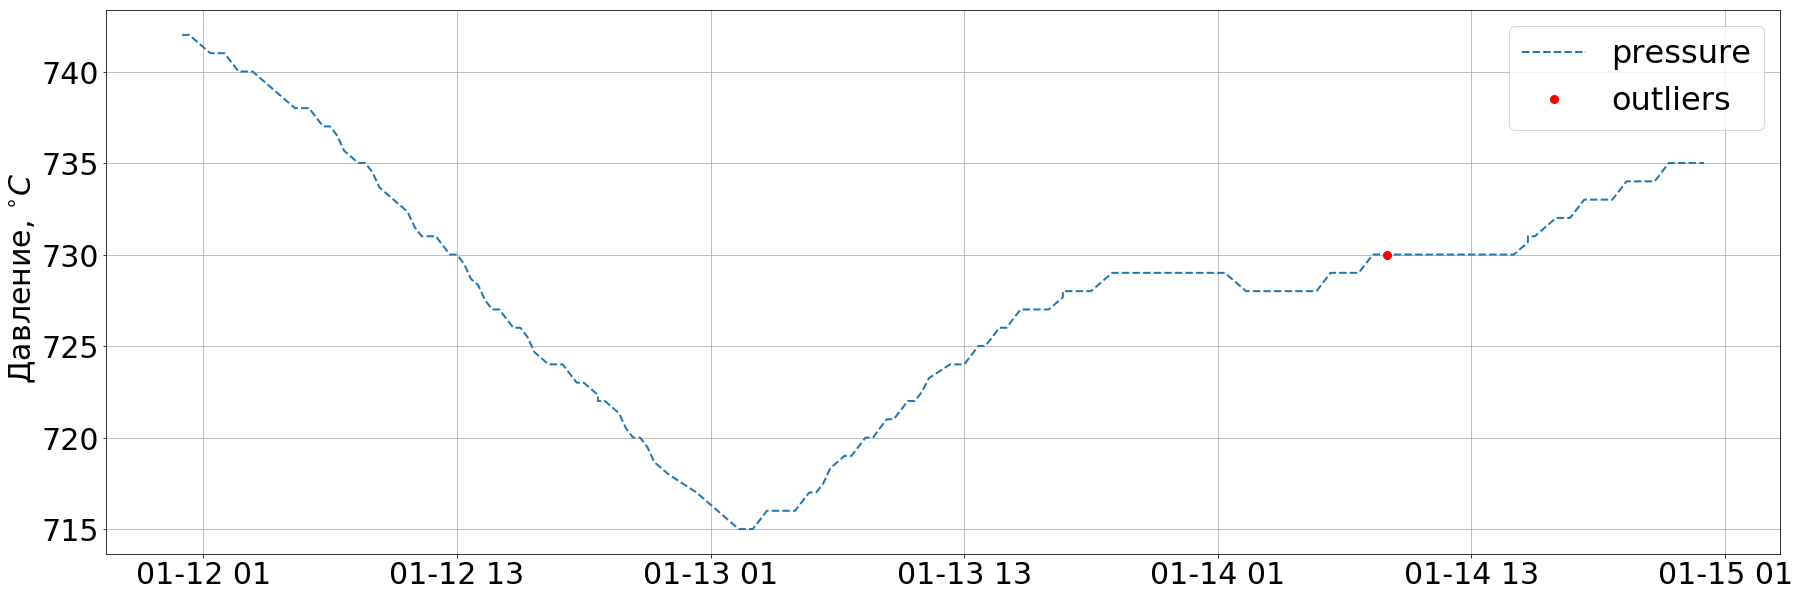

In [100]:
import matplotlib.pyplot as plt

#####-----------------------------STATION_ID-------------------------------#####
#z = copy(df_test[df_test['station_id']==119].set_index('date_time_utc'))
z = copy(df_train[df_train['station_id']==200].set_index('date_time_utc'))

#####-----------------------------TIME_INTERVAL-------------------------------#####
start = pd.Timestamp(2016, 1, 12)
end = pd.Timestamp(2016, 1, 15)
to_plot = z[(z.index<=end) & (z.index>=start)]

#####-----------------------------PREDICTION_ERROR-------------------------------#####
plt.figure(figsize=(30, 10))

error_1 = to_plot['data_dampness'] - to_plot['data_dampness'].shift(-1)
error = to_plot['data_dampness'] - to_plot['predict_dampness']

plt.plot_date(error.index, error , 'b',
                      linestyle='--', marker='None', markersize=8, label='predicted dampness')

plt.plot_date(error_1.index, error_1 , 'g',
                      linestyle='--', marker='None', markersize=8, label='predicted dampness')

plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Ошибка предсказания, %', fontsize=30)

plt.tick_params(labelsize=30)




#####-----------------------------PRESSURE-------------------------------#####
plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['predict_dampness'], 'm',
                      linestyle='--', marker='None', markersize=8, label='predicted dampness')

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['data_dampness'], 'b',
                      linestyle='none', marker='o', markersize=8, label='true dampness')
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['data_dampness'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Влажность, %', fontsize=30)

plt.tick_params(labelsize=30)


#####-----------------------------TEMPERATURE-------------------------------#####
plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot.index, to_plot['data_t_air'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_air')
        
        plt.plot_date(to_plot.index, to_plot['data_t_road'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_road')
        
        plt.plot_date(to_plot.index, to_plot['data_t_underroad'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_underroad')
        
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['data_t_air'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температуры, $^{\circ}C$', fontsize=30)

#####-----------------------------HUMIDITY-------------------------------#####
plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot.index, to_plot['data_pressure'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='pressure')
        
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['data_pressure'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Давление, $^{\circ}C$', fontsize=30)


plt.tick_params(labelsize=30)

plt.show()